# Red Neuronal Profunda (DNN) para clasificación 
MNIST Modelo 6



## Plan de Acción para preparar el modelo

1.  Preparar los datos y preprocesarlos.  Crear los conjuntos de datos para entrenar, validar y probar
2.  Crear un esboso del modelo y seleccionar las funciones de activación
3.  Fijar los optimizadores avanzados y la función de pérdida
4.  Hacer que el modelo aprenda
5.  Probar la exactitud ("accuracy") del modelo

## Importar los paquetes relevantes

TensorFlow incluye un proveedor de los datos de MNIST que utilizaremos acá.  Viene con el módulo **"tensorflow.keras.datasets"**. 

In [39]:
import numpy as np
import tensorflow as tf

In [40]:
(X_entreno, y_entreno), (X_prueba, y_prueba) = tf.keras.datasets.mnist.load_data()


In [41]:
X_entreno

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [42]:
assert X_entreno.shape == (60000, 28, 28)
assert X_prueba.shape == (10000, 28, 28)
assert y_entreno.shape == (60000,)
assert y_prueba.shape == (10000,)

## Datos

Esta sección es donde pre-procesaremos nuestros datos.

Por default, TF2 tiene conjuntos de datos de entrenamiento y de prueba, pero no tiene un conjunto de validación, por lo que debemos dividirlo por nuestra cuenta

Lo haremos del mismo tamaño que el conjunto de prueba

In [43]:
num_obs_validacion = y_prueba.shape[0]

Usaremos una variable dedicada para el número de observaciones de prueba

In [44]:
num_obs_prueba = y_prueba.shape[0]

In [45]:
X_entreno_normalizado = X_entreno / 255

In [46]:
X_prueba_normalizado = X_prueba / 255

In [47]:
X_validacion = X_entreno_normalizado[-num_obs_validacion: , : , : ]
y_validacion = y_entreno[-num_obs_validacion:]

In [48]:
X_entreno = X_entreno_normalizado[ : X_entreno_normalizado.shape[0] - num_obs_validacion, : , : ]
y_entreno = y_entreno[ : y_entreno.shape[0] - num_obs_validacion]
num_obs_entreno = y_entreno.shape[0]

Convertir de Arreglos Numpy a Tensores

In [49]:
datos_entreno = tf.data.Dataset.from_tensor_slices((X_entreno, y_entreno))
datos_validacion = tf.data.Dataset.from_tensor_slices((X_validacion, y_validacion))
datos_prueba = tf.data.Dataset.from_tensor_slices((X_prueba, y_prueba))

Barajear y hacer tandas con el conjunto de datos de entrenamiento En este caso nos piden utilizar un tamaño de tanda 10,000 para probar la eficiencia de este modelo ya que mayor tamaño menor sera el tiempo de ejecución. 

In [50]:
TAMANIO_TANDA = 10000
datos_entreno = datos_entreno.shuffle(buffer_size = num_obs_entreno).batch(TAMANIO_TANDA)

Hacer tandas con los conjuntos de validación y prueba, no se necesita barajearlos

In [51]:
datos_validacion = datos_validacion.batch(TAMANIO_TANDA)
datos_prueba = datos_prueba.batch(TAMANIO_TANDA)

## Modelo

### Delineamos el modelo

Cuando pensamos sobre un algoritmo de aprendizaje profundo, casi siempre imaginamos la realización del mismo.  Asi que esta vez, hagámoslo.  :)

In [52]:
tamanio_entrada = 784
tamanio_salida = 10

Usaremos el mismo ancho para ambas capas escondidas.  (No es una necesidad!)

In [53]:
tamanio_capa_escondida = 50

# Definimos cómo se verá el modelo

La primera capa (la de entrada):  cada observación es de 28x28 píxeles, por lo tanto es un tensor de rango 2.

Como aún no hemos aprendido sobre CNNs, no sabemos como alimentar este tipo de entrada a nuestra red, por lo tanto hay que "aplanar" las imágenes.  Hay un método conveniente **Flatten** que toma nuestro tensor de 28x28 y lo convierte en  un vector (None,) o (784,)...porque 28x28 = 784.  Esto nos permite crear una red de alimentación hacia adelante.

    
**tf.keras.layers.Dense** básicamente implementa:  *salida = activation(dot(entrada, peso) + sesgo)*.  Requiere varios argumentos, pero los más importantes para nosotros son el ancho de la capa escondida y la función de activación.

La capa final no es diferente, solo nos aseguramos de activarla con **softmax**


In [54]:
modelo = tf.keras.Sequential([

    tf.keras.layers.Flatten(input_shape=(28, 28)), # capa entrada
    
    tf.keras.layers.Dense(tamanio_capa_escondida, activation='relu'), # 1era capa escondida
    tf.keras.layers.Dense(tamanio_capa_escondida, activation='relu'), # 2nda capa escondida

    tf.keras.layers.Dense(tamanio_salida, activation='softmax') # capa salida
])

### Seleccionar el optimizador y la función de pérdida

Definimos el optimizador que nos gustaría utilizar, la función de pérdida, y las métricas que nos interesa obtener en cada interacción

In [55]:
modelo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Entrenamiento

Acá es donde entrenamos el modelo que hemos construído

Determinamos el número máximo de épocas.

Ajustamos el modelo , especificando:

* los datos de entrenamiento
* el número total de épocas
* y los datos de validación que creamos en el formato (entradas, metas)

Epoch 1/5
5/5 - 3s - 612ms/step - accuracy: 0.2377 - loss: 2.2042 - val_accuracy: 0.4069 - val_loss: 2.0416
Epoch 2/5
5/5 - 1s - 145ms/step - accuracy: 0.4673 - loss: 1.9316 - val_accuracy: 0.5405 - val_loss: 1.7428
Epoch 3/5
5/5 - 1s - 160ms/step - accuracy: 0.5695 - loss: 1.6254 - val_accuracy: 0.6245 - val_loss: 1.4256
Epoch 4/5
5/5 - 1s - 219ms/step - accuracy: 0.6523 - loss: 1.3207 - val_accuracy: 0.7221 - val_loss: 1.1291
Epoch 5/5
5/5 - 1s - 146ms/step - accuracy: 0.7409 - loss: 1.0519 - val_accuracy: 0.8039 - val_loss: 0.8843


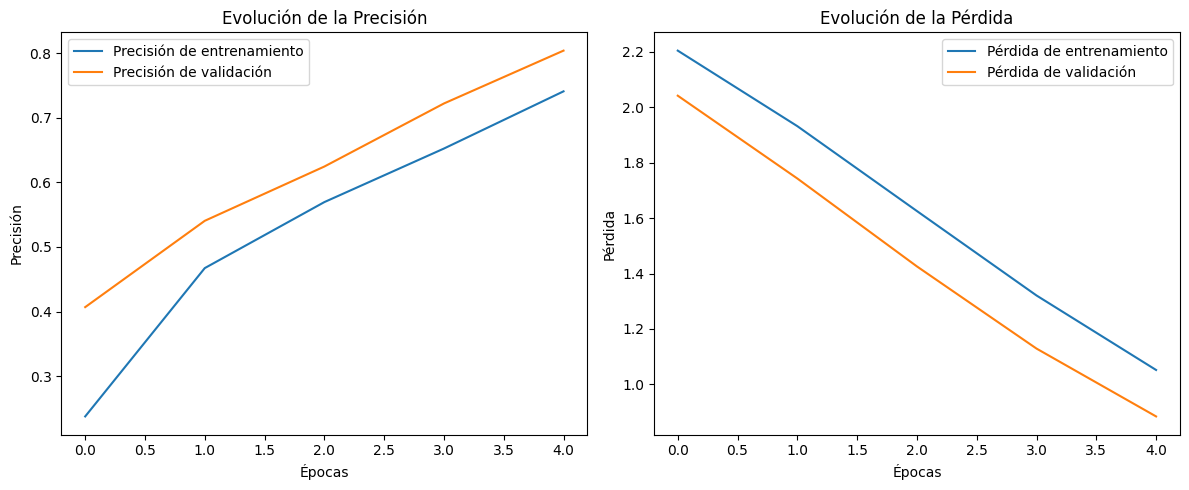

In [56]:
NUMERO_EPOCAS = 5


historial = modelo.fit(datos_entreno,
          epochs = NUMERO_EPOCAS, 
          validation_data = datos_validacion,
          verbose = 2)

import matplotlib.pyplot as plt

# Graficar precisión y pérdida
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(historial.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Precisión de validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(historial.history['loss'], label='Pérdida de entrenamiento')
plt.plot(historial.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


## Probar el modelo

Se observa en base a las gráficas que las gráficas no se intersectan por lo cual el proceso de entrenamiento es exitoso para un modelo de aprendizaje automático.Tambien revela que el rendimiento del modelo mejora constantemente, con la precisión de validación superando a la de entrenamiento en cada época, lo cual es una señal positiva de generalización. De manera similar, El de Pérdida muestra que el error del modelo disminuye consistentemente tanto en los datos de entrenamiento como en los de validación. La tendencia continua de mejora en ambas métricas, sin signos de sobreajuste.

In [57]:
perdida_prueba, precision_prueba = modelo.evaluate(datos_prueba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step - accuracy: 0.7951 - loss: 38.5855


In [58]:
# Si se desea, se puede aplicar un formateo "bonito"
print('Pérdida de prueba: {0:.2f}. Precisión de prueba: {1:.2f}%'.format(perdida_prueba, precision_prueba * 100.))

Pérdida de prueba: 38.59. Precisión de prueba: 79.51%
